Le Nutri-Score permet-il de mieux manger? 

Le Nutri-score est un système d'étiquetage nutritionnel à cinq niveaux, allant de A à E et du vert au rouge, placé sur le devant des emballages alimentaires, établi en fonction de la valeur nutritionnelle d'un produit alimentaire. Il a pour but d'aider les consommateurs à reconnaitre la qualité nutritionnelle globale des aliments et les aider à comparer les aliments entre eux, afin de favoriser le choix de produits plus favorable à la santé et ainsi de participer à la lutte contre les maladies chroniques comme les maladies cardiovasculaires, certains cancers, l'obésité et le diabète.

Nous souhaitons ici tenter de retrouver les principaux critères du Nutri-Score en regressant la valeur du nutri-score sur plusieurs variables qualitatives nutritionnelles. 
Puis nous aimerions élargir notre angle d'études en considérant d'autres critères pour quantifier la qualité d'un produit alimentaire (son niveau de transformation et sa provenance notamment). Nous crérons des scoring pour chacune des variables qu'on travaillerait. 
Enfin, nous aimerions mettre en évidence les différents catégories de produits alimentaires en utilisant des algorithmes de clustering à partir de nos scorings. 

Nous travaillerons sur la base de donnée OpenFoodFacts. Open Food Facts est un projet collaboratif dont le but est de constituer une base de données libre et ouverte sur les produits alimentaires commercialisés dans le monde entier. 
La première étape de notre projet est donc de nettoyer cette base de donnée très dense afin de pouvoir commencer nos analyses. 
Nous bornerons notre étude aux produits vendus en France, en ne gardant que les variables qui nous intéressent, pour cela on gardera les produits alimentaires qui auront toutes les variables d'intérêts renseignées.  

On importe les librairies Python qu'on utilisera dans le projet 

In [2]:
#On importe les modules nécessaires au traitement de la base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from googletrans import Translator
from translate import Translator





In [3]:
!pip install translate
!pip install googletrans==4.0.0-rc1




On importe la base de donnée OpenFoodFacts

In [5]:
# Charger le fichier CSV
url_path = 'https://www.data.gouv.fr/fr/datasets/r/164c9e57-32a7-4f5b-8891-26af10f91072'
# Charger le fichier CSV dans un DataFrame pandas
df_openfoodfacts = pd.read_csv(url_path, sep='\t',low_memory=True)  # Assurez-vous de spécifier le bon séparateur s'il est différent de la virgule


/tmp/ipykernel_77752/2182459212.py:4: DtypeWarning: Columns (0,9,15,21,22,23,29,30,31,32,33,42,44,49,50,51,54,65,70,148) have mixed types. Specify dtype option on import or set low_memory=False.
  df_openfoodfacts = pd.read_csv(url_path, sep='\t',low_memory=True)  # Assurez-vous de spécifier le bon séparateur s'il est différent de la virgule


On veut connaître ses dimensions avant nettoyage

In [7]:
#On vérifie que la base est bien chargée
#on affiche 5 lignes aléatoires 
print(df_openfoodfacts.sample(5))

#on veut connaître la taille de la base
print ("Le dataframe compte {} lignes et {} variables".format(df_openfoodfacts.shape[0], df_openfoodfacts.shape[1]))


                  code                                                url  \
1938668  5010228078021  http://world-fr.openfoodfacts.org/produit/5010...   
1272989  3279130105566  http://world-fr.openfoodfacts.org/produit/3279...   
202389     49705662687  http://world-fr.openfoodfacts.org/produit/0049...   
2372639  7894904051939  http://world-fr.openfoodfacts.org/produit/7894...   
1868864  4337256086707  http://world-fr.openfoodfacts.org/produit/4337...   

               creator   created_t      created_datetime  last_modified_t  \
1938668  waistline-app  1559231240  2019-05-30T15:47:20Z       1689797134   
1272989        kiliweb  1522607681  2018-04-01T18:34:41Z       1656943670   
202389         kiliweb  1661472131  2022-08-26T00:02:11Z       1693260211   
2372639        kiliweb  1583857996  2020-03-10T16:33:16Z       1583857997   
1868864         sargon  1663178954  2022-09-14T18:09:14Z       1677917715   

        last_modified_datetime last_modified_by  \
1938668   2023-07-19T20

On commence le nettoyage de la base de donnée OpenFoodFacts: on ne garde que les produits français 

In [98]:
# Obtention des valeurs distinctes de la colonne 'countries_tags' sans les valeurs nulles
valeurs_distinctes = df_france['countries_tags'].dropna().drop_duplicates().tolist()

# Tri des valeurs distinctes en ordre alphabétique
valeurs_distinctes.sort()

for valeur in valeurs_distinctes:
    print(valeur)

#On remarque que la France apparrait sous différentes formes, comme "fr:France", "en:France" ou encore "de:Frankreich".
#un peu de travail est nécéssaire pour récupérer tous les produits vendus en France




en:france


In [99]:
# Filtrer le DataFrame pour ne conserver que les lignes avec 'en:france' dans la colonne 'countries_tags'
df_france = df_openfoodfacts[df_openfoodfacts['countries_tags'] == 'en:france']
# Afficher les premières lignes du DataFrame résultant
print(df_france.head())

#on veut connaître la taille de la base
print ("Le dataframe compte {} lignes et {} variables".format(df_france.shape[0], df_france.shape[1]))

                    code                                                url  \
0      00000000000000225  http://world-fr.openfoodfacts.org/produit/0000...   
3   00000000000026772226  http://world-fr.openfoodfacts.org/produit/0000...   
4          0000000000017  http://world-fr.openfoodfacts.org/produit/0000...   
5          0000000000031  http://world-fr.openfoodfacts.org/produit/0000...   
11         0000000000100  http://world-fr.openfoodfacts.org/produit/0000...   

           creator   created_t      created_datetime  last_modified_t  \
0   nutrinet-sante  1623855208  2021-06-16T14:53:28Z       1692101569   
3          kiliweb  1654250311  2022-06-03T09:58:31Z       1654270474   
4          kiliweb  1529059080  2018-06-15T10:38:00Z       1561463718   
5         isagoofy  1539464774  2018-10-13T21:06:14Z       1539464817   
11           del51  1444572561  2015-10-11T14:09:21Z       1444659212   

   last_modified_datetime last_modified_by                  product_name  \
0    2023-

In [100]:
# Filtrer le DataFrame pour ne conserver que les lignes avec 'en:france' dans la colonne 'countries_tags'
df_france = df_openfoodfacts[df_openfoodfacts['countries_tags'] == 'en:france']
# Afficher les premières lignes du DataFrame résultant
print(df_france.head())

#on veut connaître la taille de la base
print ("Le dataframe compte {} lignes et {} variables".format(df_france.shape[0], df_france.shape[1]))


                    code                                                url  \
0      00000000000000225  http://world-fr.openfoodfacts.org/produit/0000...   
3   00000000000026772226  http://world-fr.openfoodfacts.org/produit/0000...   
4          0000000000017  http://world-fr.openfoodfacts.org/produit/0000...   
5          0000000000031  http://world-fr.openfoodfacts.org/produit/0000...   
11         0000000000100  http://world-fr.openfoodfacts.org/produit/0000...   

           creator   created_t      created_datetime  last_modified_t  \
0   nutrinet-sante  1623855208  2021-06-16T14:53:28Z       1692101569   
3          kiliweb  1654250311  2022-06-03T09:58:31Z       1654270474   
4          kiliweb  1529059080  2018-06-15T10:38:00Z       1561463718   
5         isagoofy  1539464774  2018-10-13T21:06:14Z       1539464817   
11           del51  1444572561  2015-10-11T14:09:21Z       1444659212   

   last_modified_datetime last_modified_by                  product_name  \
0    2023-

On souhaite visualiser d'un coup d'oeil les variables d'intérêt de la base de donnée: quelles variables pourrons nous être utiles pour notre analyse? lesquelles sont assez remplies pour nous être utiles? 

/tmp/ipykernel_77752/2740516386.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")


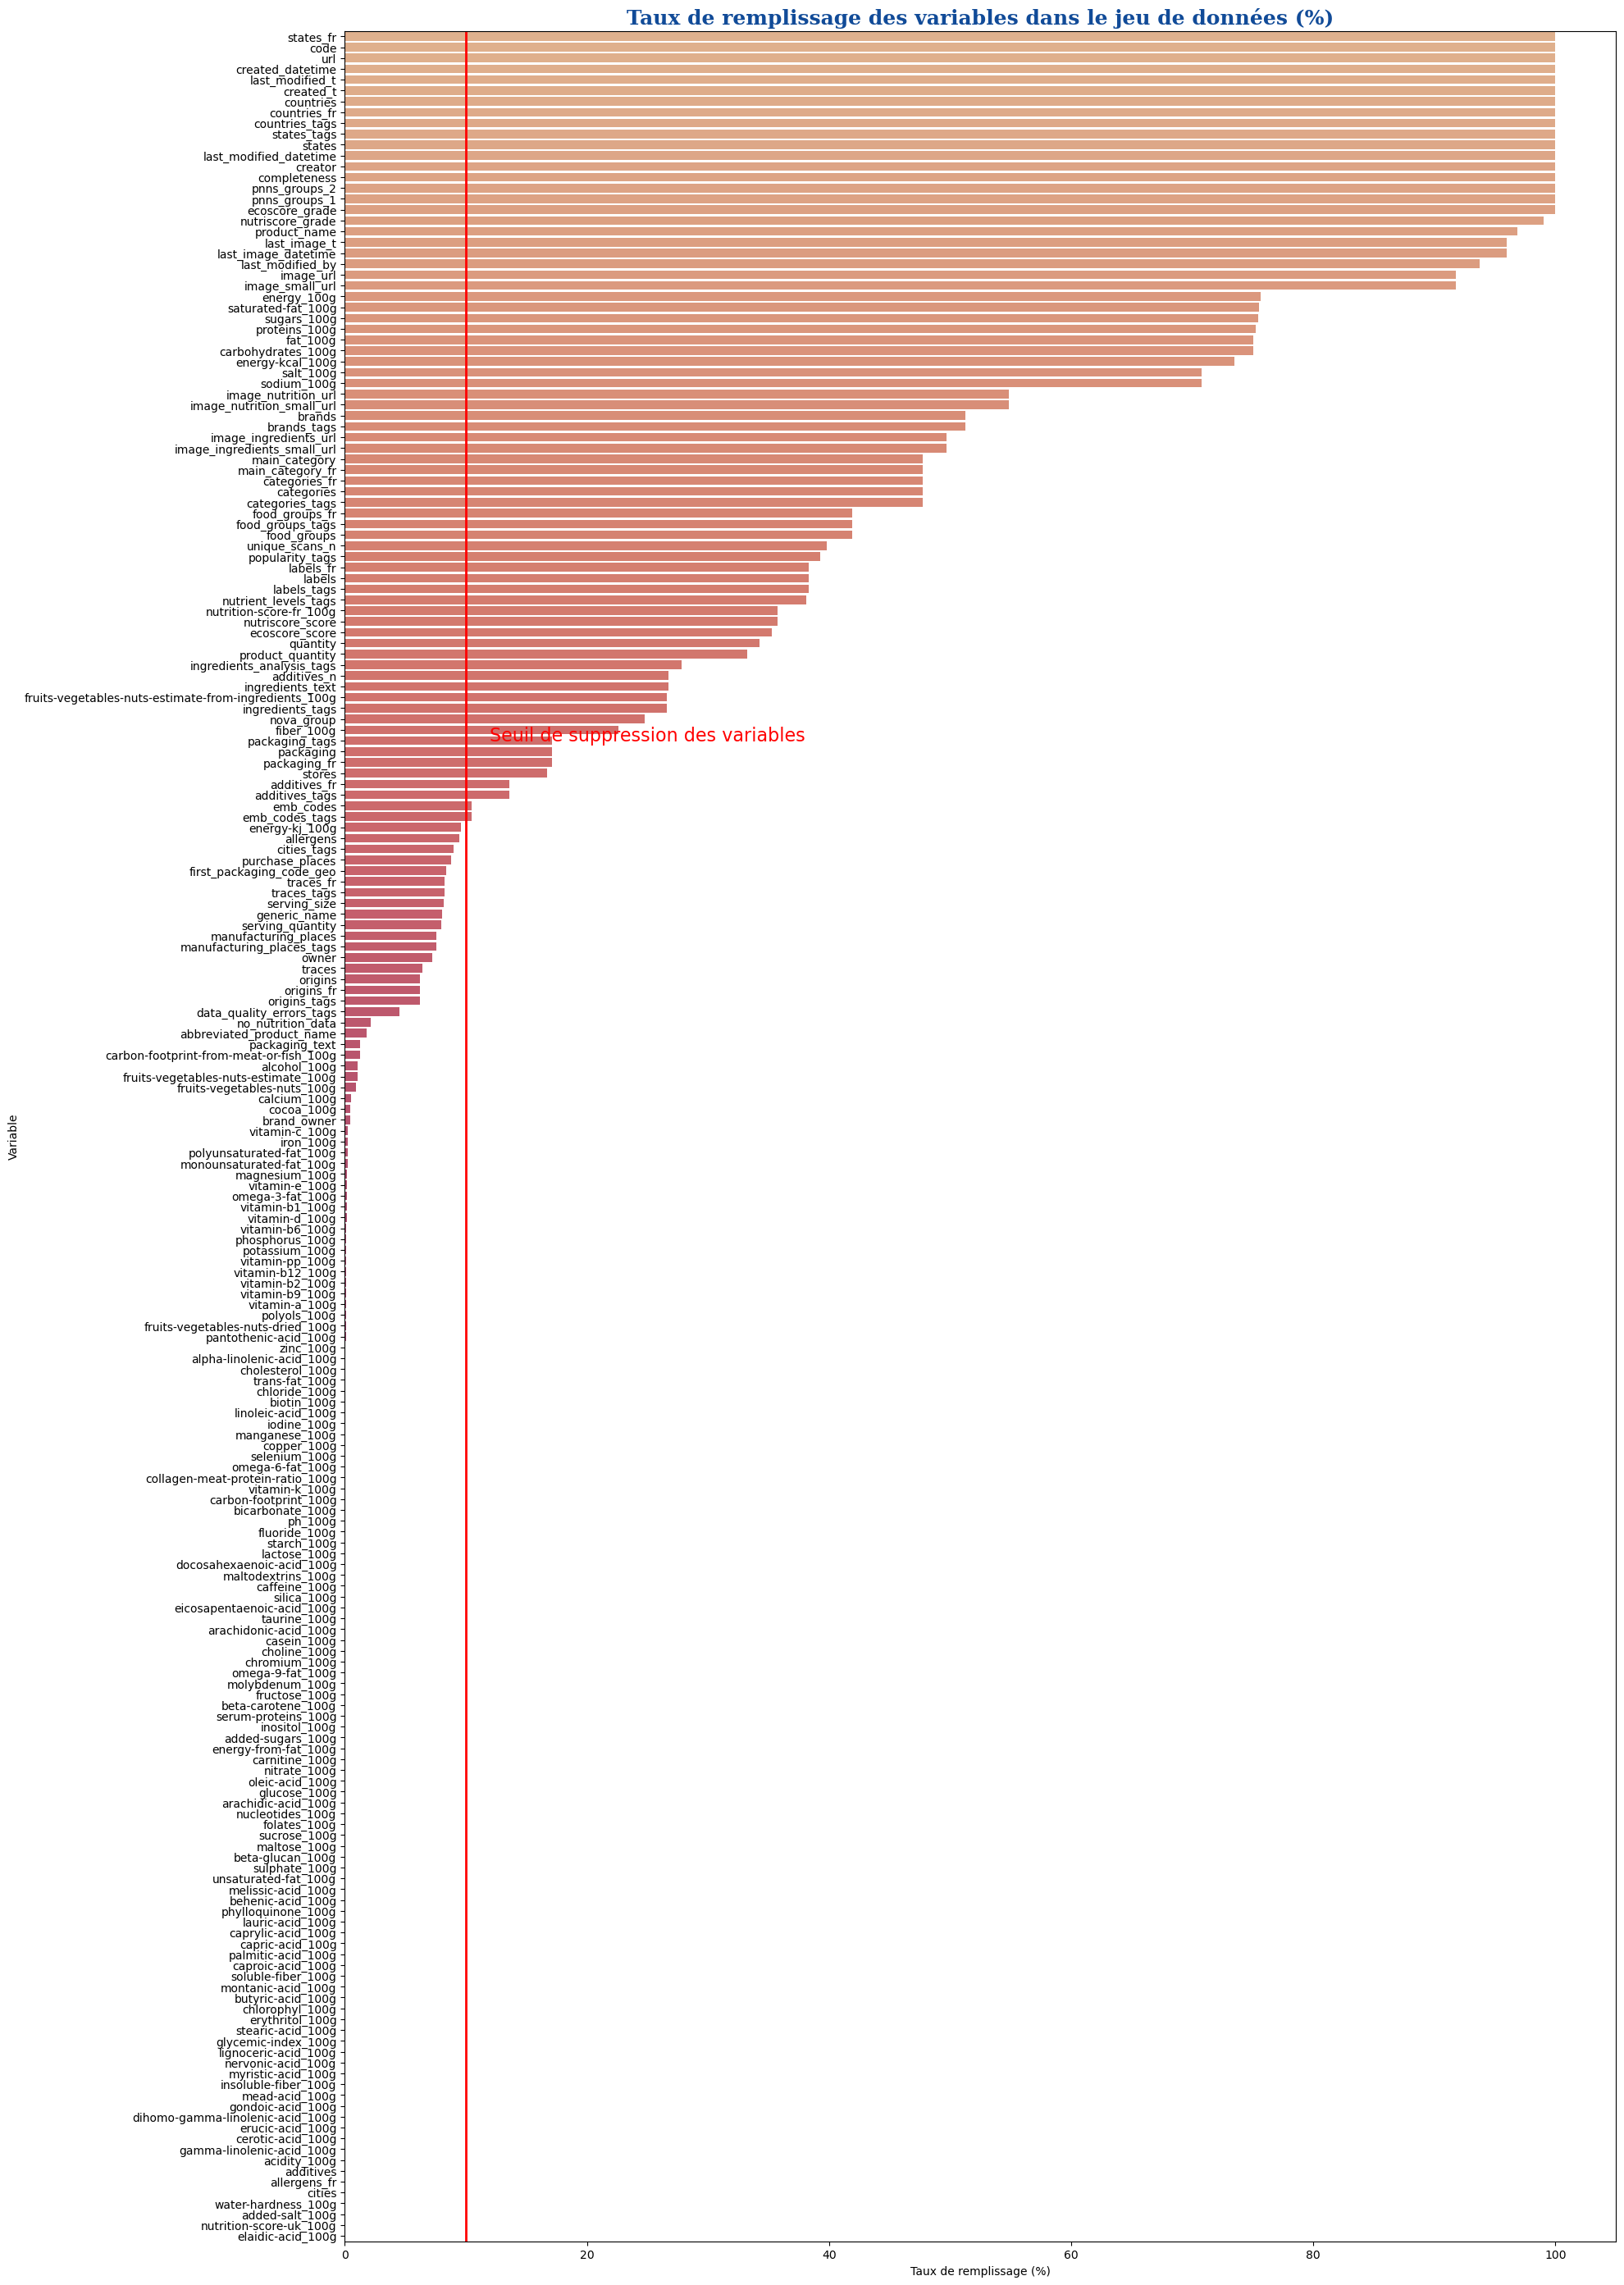

In [101]:
#On calcule le taux de remplissage de chaque variable
def null_factor(df):
  null_rate = ((df.isnull().sum() / df.shape[0])*100).sort_values(ascending=False).reset_index()
  null_rate.columns = ['Variable','Taux_de_Null']
  return null_rate

#Nous alllons désormais commencer à nettoyer la base de données en enlevant les colonnes peu remplis. 
filling_features = null_factor(df_france)
filling_features["Taux_de_Null"] = 100-filling_features["Taux_de_Null"]
filling_features = filling_features.sort_values("Taux_de_Null", ascending=False) 

#Seuil de suppression
sup_threshold = 10

#On affiche le taux de remplissages des variables en fonction d'un seuil de référence
fig = plt.figure(figsize=(20, 35))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")
#Seuil pour suppression des varaibles
plt.axvline(x=sup_threshold, linewidth=2, color = 'r')
plt.text(sup_threshold+2, 65, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de remplissage des variables dans le jeu de données (%)", fontdict=font_title)
plt.xlabel("Taux de remplissage (%)")
plt.show()

On va supprimer les colonnes qui ne sont pas remplies à + de 10% 

In [102]:
#On ne décide de ne garder que les colonnes remplis à plus de 10%
seuil = 10  
filled_variables = list(filling_features.loc[filling_features['Taux_de_Null'] >= seuil, 'Variable'].values)

#Nouveau Dataset avec les variables conservées
df_france = df_france[filled_variables]

# Affichage du résultat
print ("Le dataframe df_france compte {} lignes et {} variables".format(df_france.shape[0], df_france.shape[1]))

for column_name in df_france.columns:
    print(column_name)

Le dataframe df_france compte 924867 lignes et 73 variables
states_fr
code
url
created_datetime
last_modified_t
created_t
countries
countries_fr
countries_tags
states_tags
states
last_modified_datetime
creator
completeness
pnns_groups_2
pnns_groups_1
ecoscore_grade
nutriscore_grade
product_name
last_image_t
last_image_datetime
last_modified_by
image_url
image_small_url
energy_100g
saturated-fat_100g
sugars_100g
proteins_100g
fat_100g
carbohydrates_100g
energy-kcal_100g
salt_100g
sodium_100g
image_nutrition_url
image_nutrition_small_url
brands
brands_tags
image_ingredients_url
image_ingredients_small_url
main_category
main_category_fr
categories_fr
categories
categories_tags
food_groups_fr
food_groups_tags
food_groups
unique_scans_n
popularity_tags
labels_fr
labels
labels_tags
nutrient_levels_tags
nutrition-score-fr_100g
nutriscore_score
ecoscore_score
quantity
product_quantity
ingredients_analysis_tags
additives_n
ingredients_text
fruits-vegetables-nuts-estimate-from-ingredients_100g
i

On allège de nouveau la base de donnée en enlevant les variables qui ne nous intéresse pas pour la suite (celles qui contiennent des images des produits notamment par exemple et qui consomment beaucoup de place)

In [103]:
#On supprime les variables inutiles pour le reste du projet pour alléger la base
useless_columns = [col for col in df_france.columns if 'url' in col or 'image' in col or "categories" in col or "last" in col or "states" in col or "creator" in col ]
df_france = df_france.drop(columns=useless_columns)

print ("Le dataframe df_france compte {} lignes et {} variables".format(df_france.shape[0], df_france.shape[1]))

#On affiche le nom des colonnes restantes
for column_name in df_france.columns:
    print(column_name)


Le dataframe df_france compte 924867 lignes et 54 variables
code
created_datetime
created_t
countries
countries_fr
countries_tags
completeness
pnns_groups_2
pnns_groups_1
ecoscore_grade
nutriscore_grade
product_name
energy_100g
saturated-fat_100g
sugars_100g
proteins_100g
fat_100g
carbohydrates_100g
energy-kcal_100g
salt_100g
sodium_100g
brands
brands_tags
main_category
main_category_fr
food_groups_fr
food_groups_tags
food_groups
unique_scans_n
popularity_tags
labels_fr
labels
labels_tags
nutrient_levels_tags
nutrition-score-fr_100g
nutriscore_score
ecoscore_score
quantity
product_quantity
ingredients_analysis_tags
additives_n
ingredients_text
fruits-vegetables-nuts-estimate-from-ingredients_100g
ingredients_tags
nova_group
fiber_100g
packaging_tags
packaging
packaging_fr
stores
additives_fr
additives_tags
emb_codes
emb_codes_tags


In [104]:
#On ne garde que les observations où les informations nutritionneles sont complétées  


df_france = df_france[(df_france['nutriscore_grade'].notnull()) & (df_france['ecoscore_grade'].notnull()) & (df_france['fiber_100g'].notnull()) & (df_france['energy_100g'].notnull()) & (df_france['saturated-fat_100g'].notnull())  & (df_france['sugars_100g'].notnull())  & (df_france['proteins_100g'].notnull()) & (df_france['fat_100g'].notnull()) & (df_france['salt_100g'].notnull()) & (df_france['carbohydrates_100g'].notnull()) & (df_france['sodium_100g'].notnull())]

print(df_france.describe())

print ("Le dataframe df_france compte {} lignes et {} variables".format(df_france.shape[0], df_france.shape[1]))


          created_t   completeness   energy_100g  saturated-fat_100g  \
count  1.890740e+05  189074.000000  1.890740e+05       189074.000000   
mean   1.552506e+09       0.640903  3.146916e+11            4.457223   
std    8.545937e+07       0.233159  1.368362e+14            7.183998   
min    1.328784e+09       0.100000  0.000000e+00            0.000000   
25%    1.498404e+09       0.475000  4.420000e+02            0.200000   
50%    1.524221e+09       0.668750  1.038000e+03            1.600000   
75%    1.637427e+09       0.800000  1.648000e+03            5.700000   
max    1.703733e+09       1.100000  5.950000e+16          100.000000   

         sugars_100g  proteins_100g       fat_100g  carbohydrates_100g  \
count  189074.000000  189074.000000  189074.000000       189074.000000   
mean       12.771961       8.240467      12.575081           28.906773   
std        18.415129       9.544333      16.477711           27.025746   
min         0.000000       0.000000       0.000000     

In [105]:
#On continue le nettoyage de la base en enlevant les valeurs abérrantes
#Open food fact est une base open source ouverte à tous. Il n'est pas abérrant de penser que des erreurs ont pu se produire lors  de l'entrée de certaines données

def suppression_aberrations(df):
    # Cette fonction supprime les observations où les valeurs sont aberrantes

    var_pour_100g = ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']

    for var in var_pour_100g:
        df = df[(df[var] >= 0) & (df[var] <= 100)]

    return df


In [106]:
#On regarde combien d'observations étaient abérrantes

ni=df_france.shape[0] 

# Appliquer la fonction sur le DataFrame
df_france = suppression_aberrations(df_france)

nf=df_france.shape[0]

delta_lignes=ni-nf #Controle du nombre de lignes supprimées 

print(delta_lignes,"lignes considérées comme des abérrations et donc supprimées")


30 lignes considérées comme des abérrations et donc supprimées


In [107]:
#Transformons le Nutriscore et l'ecoscore en variable quantitative, ce qui sera utile pour faire des régressions
def convertion_num_score(lettre):
    if lettre =="a":
        score=1
    elif lettre == "b":
        score=2
    elif lettre == "c":
        score=3
    elif lettre == "d":
        score=4
    elif lettre == "e":
        score=5
    else:
        score=np.nan
    return score

df_france["nutriscore_num"]=df_france['nutriscore_grade'].apply(convertion_num_score)
df_france["ecoscore_num"]=df_france['ecoscore_grade'].apply(convertion_num_score)

/tmp/ipykernel_77752/2363808983.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")


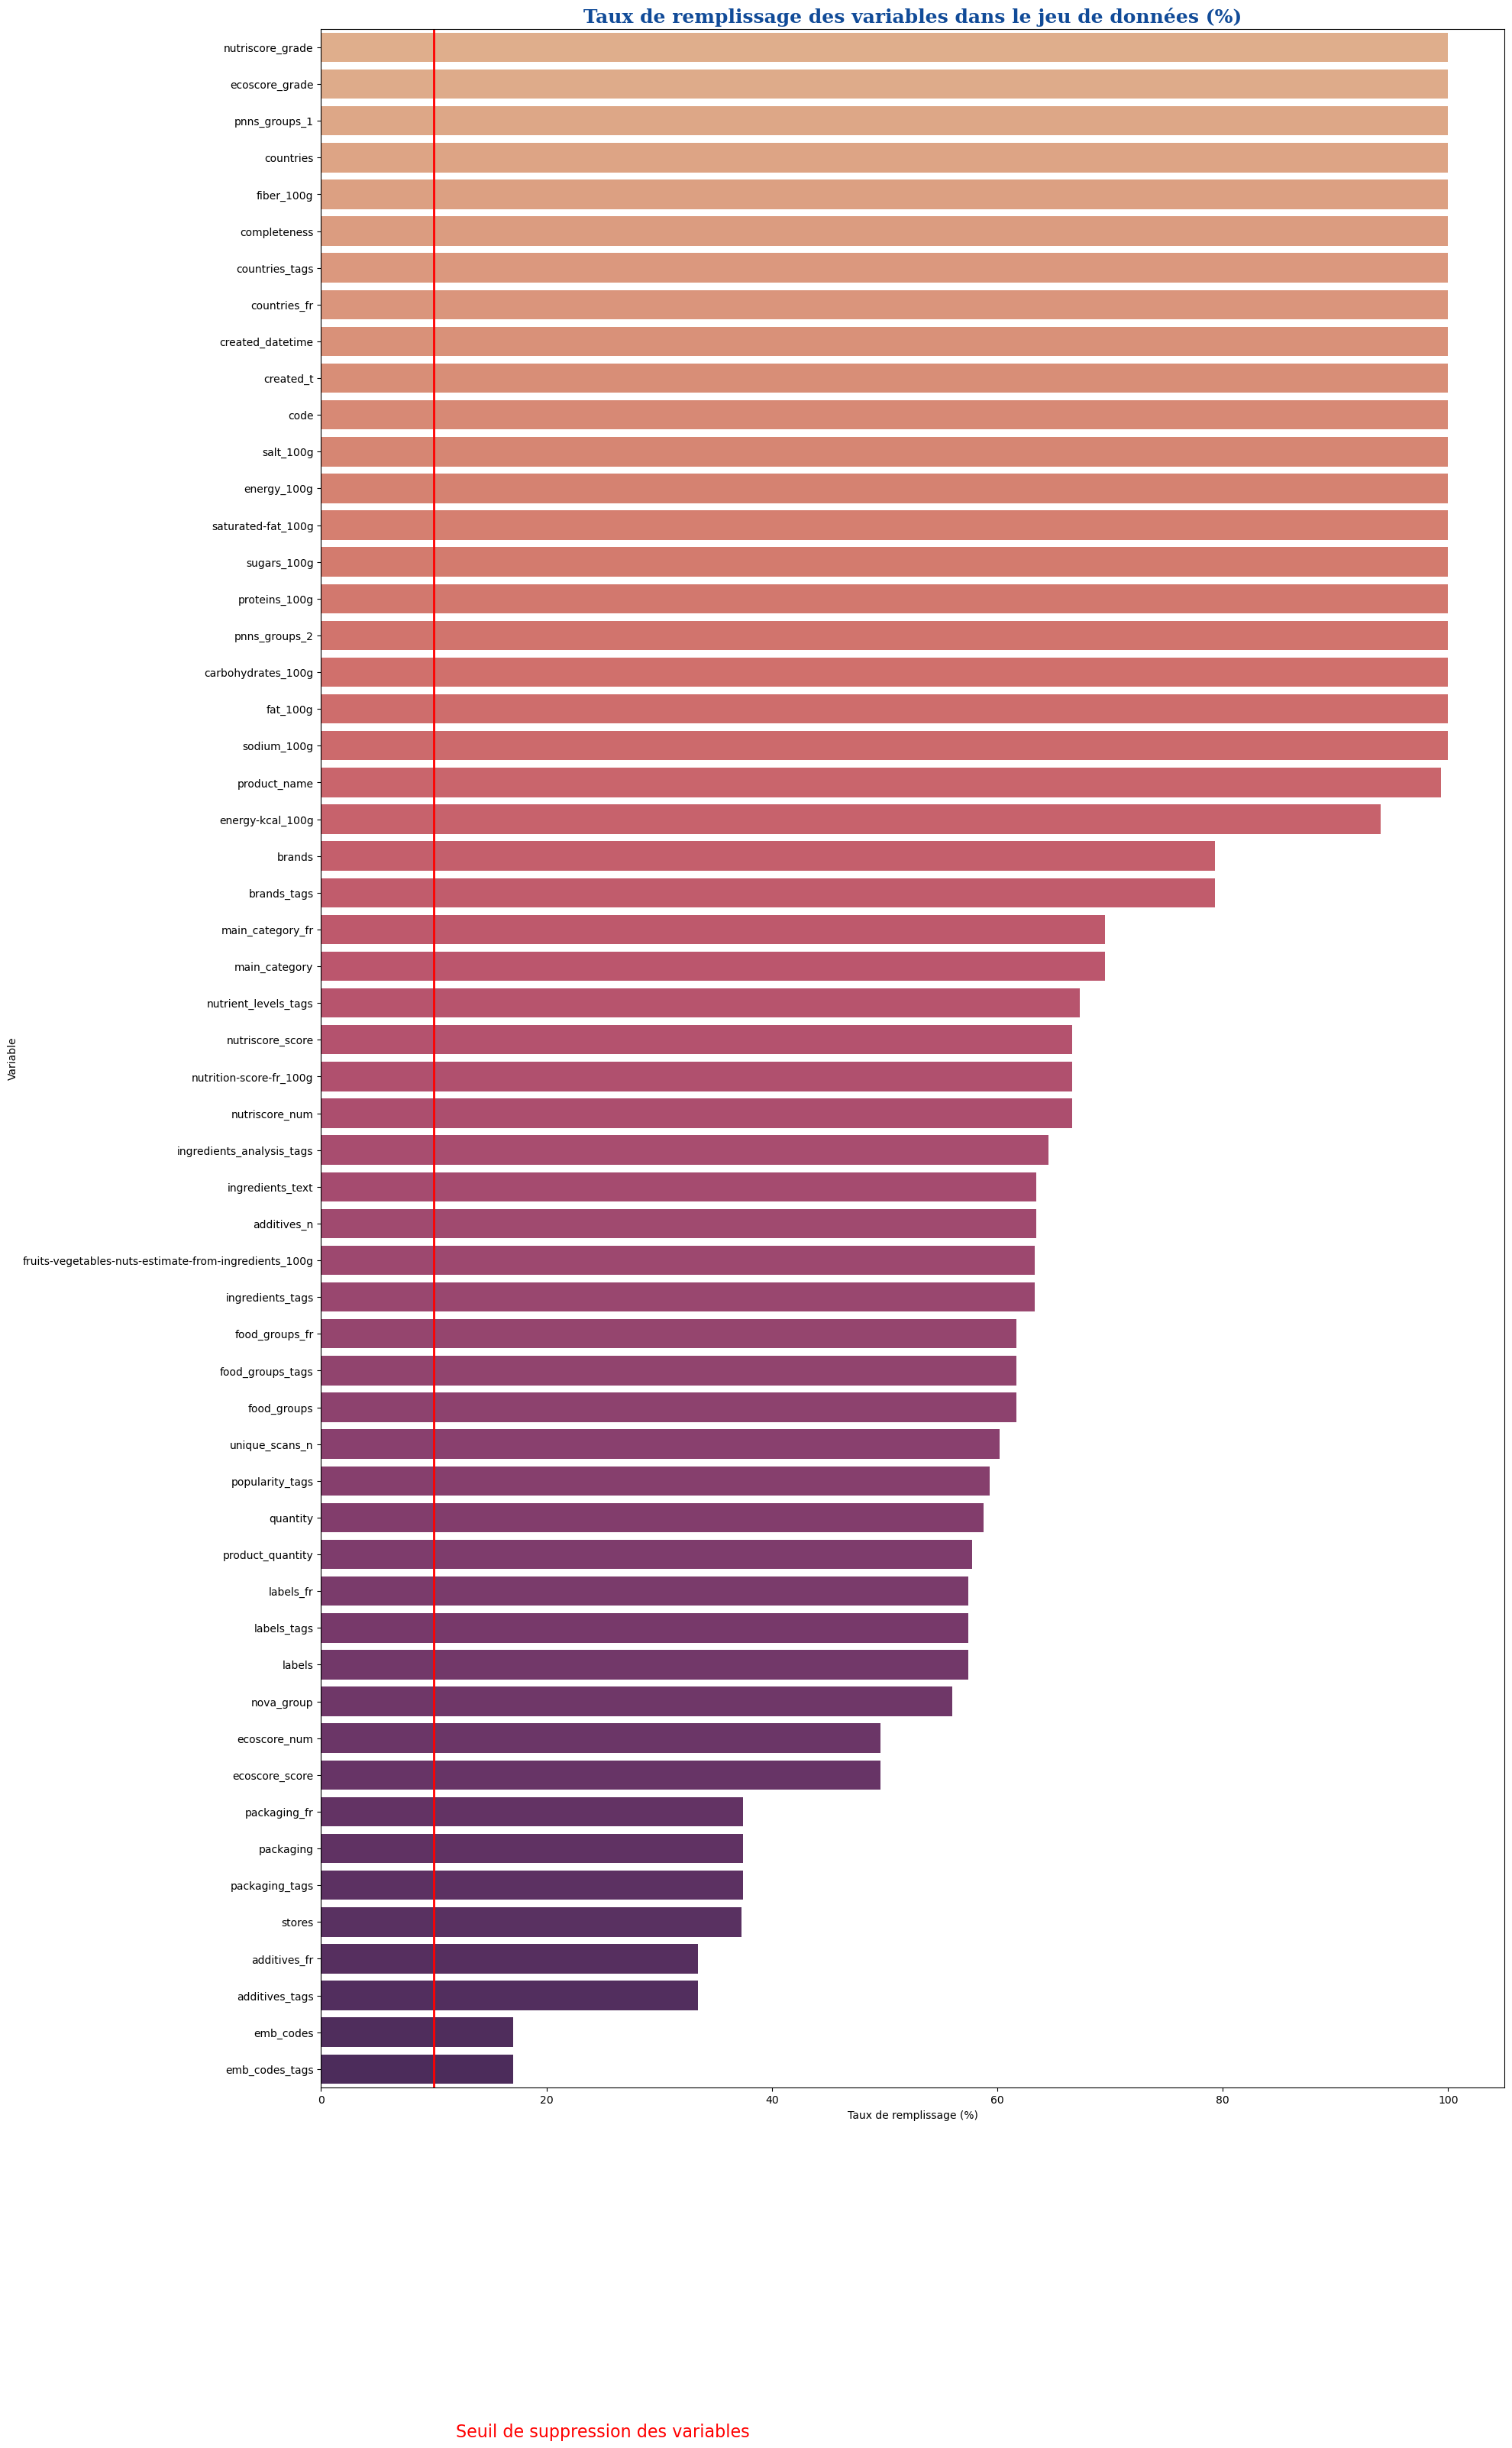

In [108]:
#On affiche des informations sur la base finale

filling_features = null_factor(df_france)
filling_features["Taux_de_Null"] = 100-filling_features["Taux_de_Null"]
filling_features = filling_features.sort_values("Taux_de_Null", ascending=False) 
fig = plt.figure(figsize=(20, 35))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")
#Seuil pour suppression des varaibles
plt.axvline(x=sup_threshold, linewidth=2, color = 'r')
plt.text(sup_threshold+2, 65, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de remplissage des variables dans le jeu de données (%)", fontdict=font_title)
plt.xlabel("Taux de remplissage (%)")
plt.show()

On réalise désormais des statistiques descriptives 
On commence par étudier le Nutriscore, qui est le principal score utilisé pour déterminer la qualitée nutritionnelles 

On commence par montrer la répartition du score du Nutriscore dans la base. 

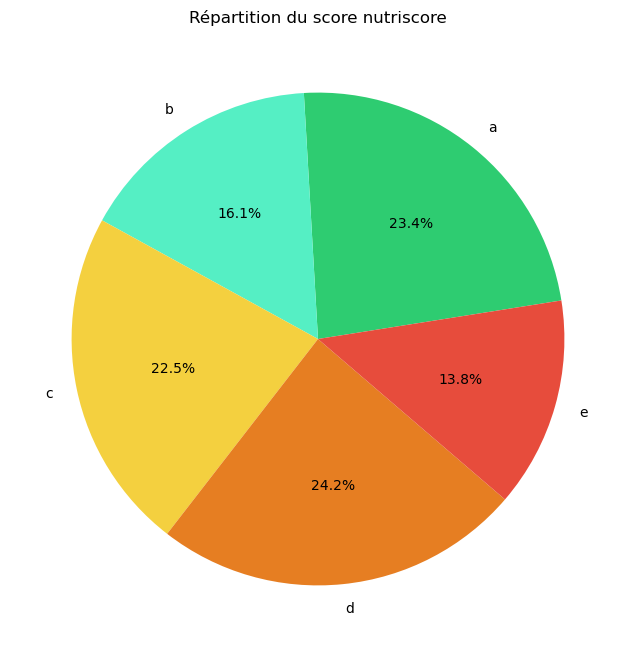

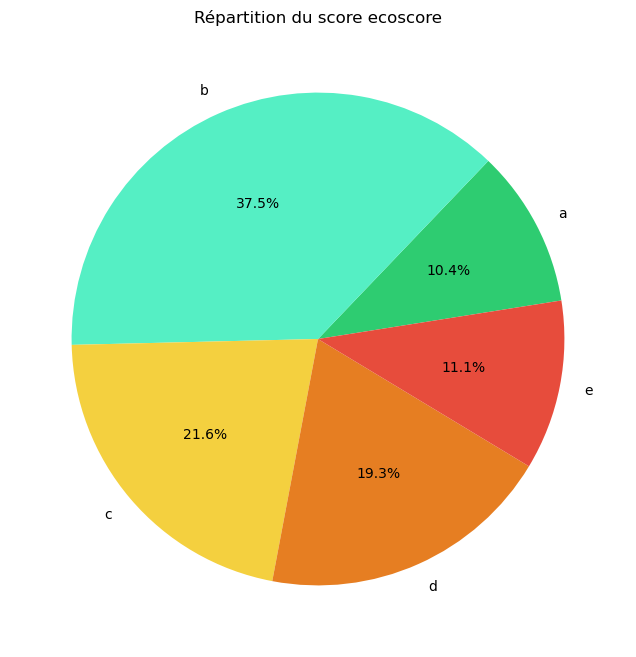

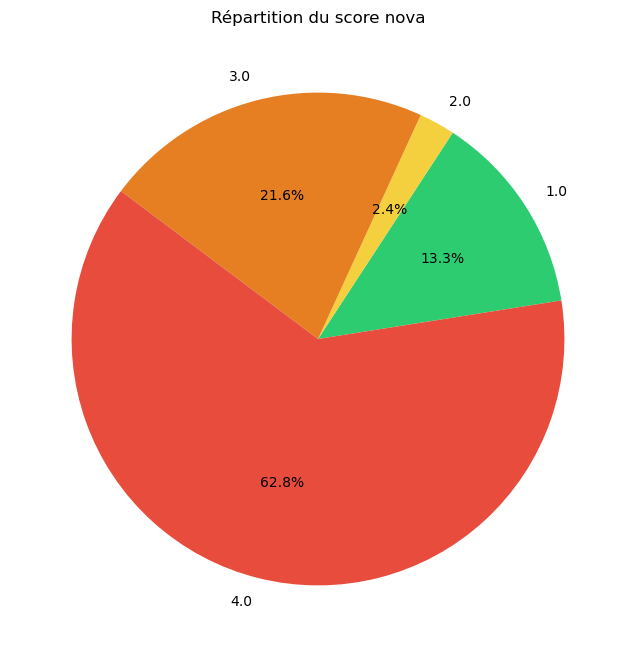

In [19]:

def plot_pie(score):
    # Filtrer les données pour exclure la catégorie 'Unknown' et 'non-applicable'

    filtered_data = df_france[(df_france[score] != 'unknown') & (df_france[score] != 'not-applicable')]

    # Compter les occurrences des valeurs dans la colonne 'nutriscore_grade' et trier par index (ordre alphabétique)
    score_counts = filtered_data[score].value_counts().sort_index()

    nutriscore_colors = {'a': '#2ecc71', 'b': '#55efc4', 'c': '#f4d03f', 'd': '#e67e22', 'e': '#e74c3c', '1.0': '#2ecc71', '2.0': '#f4d03f', '3.0': '#e67e22', '4.0': '#e74c3c'}
    colors = [nutriscore_colors.get(str(category), '#95a5a6') for category in score_counts.index]

    # Créer le diagramme circulaire avec les couleurs spécifiques du Nutri-Score
    plt.figure(figsize=(8, 8))
    plt.pie(score_counts, labels=score_counts.index, autopct='%1.1f%%', startangle=9, colors=colors)
    score_name = score.split("_")
    plt.title('Répartition du score ' + score_name[0])
    plt.show()


#On affiche les différentes scores
plot_pie("nutriscore_grade")
plot_pie("ecoscore_grade")
plot_pie("nova_group")

/tmp/ipykernel_77752/2877764784.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['year'] = filtered_data['created_datetime'].dt.year


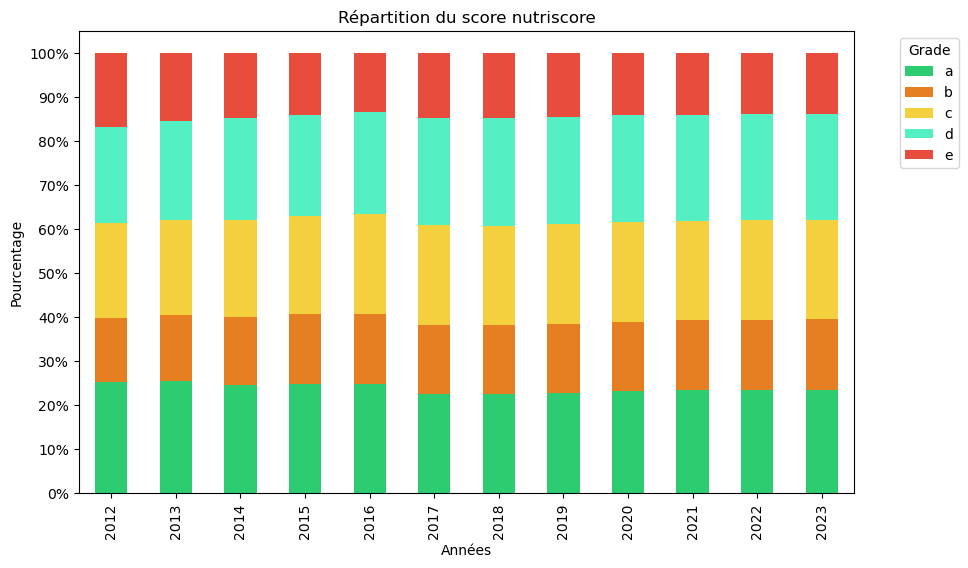

/tmp/ipykernel_77752/2877764784.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['year'] = filtered_data['created_datetime'].dt.year


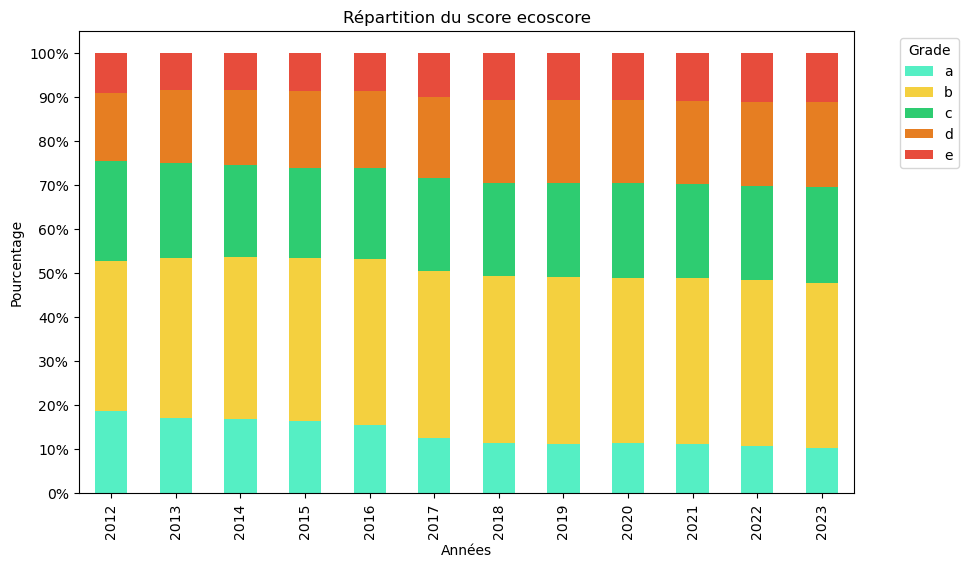

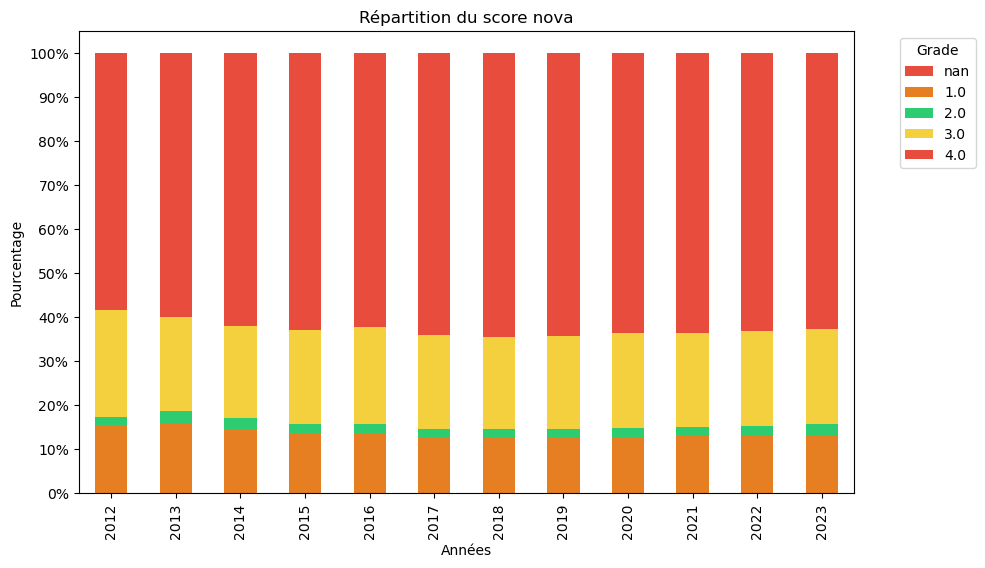

In [36]:
def time_evolution(score):

    # Filtrer les données pour exclure la catégorie 'Unknown' et 'non-applicable'
    filtered_data = df_france[(df_france[score] != 'unknown') & (df_france[score] != 'not-applicable')]

    

    # Extract year from the 'created_datetime' column
    filtered_data['year'] = filtered_data['created_datetime'].dt.year

    # On crée un nouveau dataframe pour manipuler les données utiles pour le graphique
    cumulative_df = pd.DataFrame(index=filtered_data['year'].unique(), columns=filtered_data[score].unique())

    # On calcule le nombre d'occurences par note et par an 
    for year in cumulative_df.index:
        year_data = filtered_data[filtered_data['year'] <= year]
        counts = year_data[score].value_counts(normalize=True) * 100  # Calculate percentages
        cumulative_df.loc[year] = counts

    # On affiche les années dans l'ordre
    cumulative_df.sort_index(inplace=True)
    cumulative_df = cumulative_df[sorted(cumulative_df.columns)]


    #On affiche le graphique 
    nutriscore_colors = {'a': '#2ecc71', 'b': '#55efc4', 'c': '#f4d03f', 'd': '#e67e22', 'e': '#e74c3c',
                         '1.0': '#2ecc71', '2.0': '#f4d03f', '3.0': '#e67e22', '4.0': '#e74c3c'}

    colors = [nutriscore_colors.get(str(category), '#95a5a6') for category in counts.index]

    cumulative_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
    
    #On affiche le titre et la légende
    score_name = score.split("_")
    plt.title('Répartition du score ' + score_name[0]) 
    plt.legend(title='Grade', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylabel('Pourcentage')
    plt.xlabel('Années')
    plt.yticks(range(0, 101, 10), [f'{i}%' for i in range(0, 101, 10)])

    plt.show()

time_evolution("nutriscore_grade")
time_evolution("ecoscore_grade")
time_evolution("nova_group")



/tmp/ipykernel_77752/2899663442.py:18: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  ax = sns.lineplot(x='year', y='score_rate', hue=score, data=score_per_year, palette = colors)


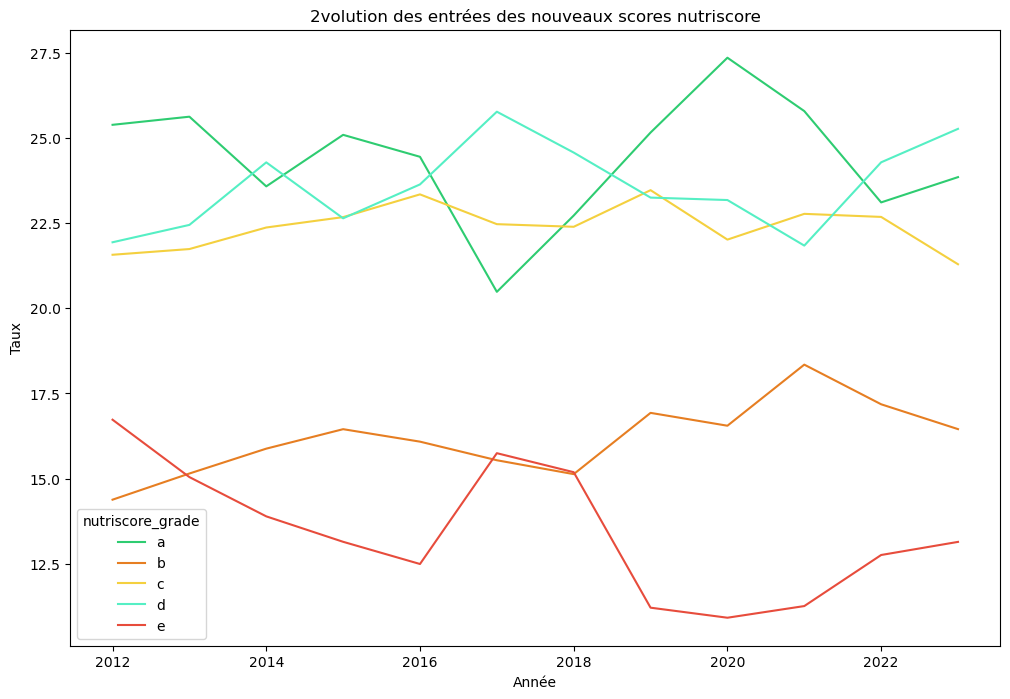

In [72]:
def new_creation_time(score):

    filtered_data = df_france[(df_france[score] != 'unknown') & (df_france[score] != 'not-applicable')]

    score_per_year = filtered_data[['code', score]].groupby(by=[score,filtered_data['created_datetime'].dt.year]).nunique().reset_index()
    cum_per_year = filtered_data[['code']].groupby(by=filtered_data['created_datetime'].dt.year).nunique().reset_index()
    score_per_year = pd.merge(score_per_year, cum_per_year, how="left", left_on="created_datetime", right_on="created_datetime")
    score_per_year = score_per_year.rename(columns={'created_datetime':'year', 'code_x':'nb_score', 'code_y':'total_grade'})
    score_per_year['score_rate'] = (score_per_year['nb_score'] / score_per_year['total_grade'])*100


    nutriscore_colors = {'a': '#2ecc71', 'b': '#55efc4', 'c': '#f4d03f', 'd': '#e67e22', 'e': '#e74c3c',
                         '1.0': '#2ecc71', '2.0': '#f4d03f', '3.0': '#e67e22', '4.0': '#e74c3c'}

    colors = [nutriscore_colors.get(str(category), '#95a5a6') for category in counts.index]

    fig =plt.figure(figsize=(12,8))
    ax = sns.lineplot(x='year', y='score_rate', hue=score, data=score_per_year, palette = colors)
    plt.xlabel("Année")
    plt.ylabel("Taux")

    score_name = score.split("_")
    plt.title('2volution des entrées des nouveaux scores ' + score_name[0]) 
    
    plt.show()

new_creation_time("nutriscore_grade")

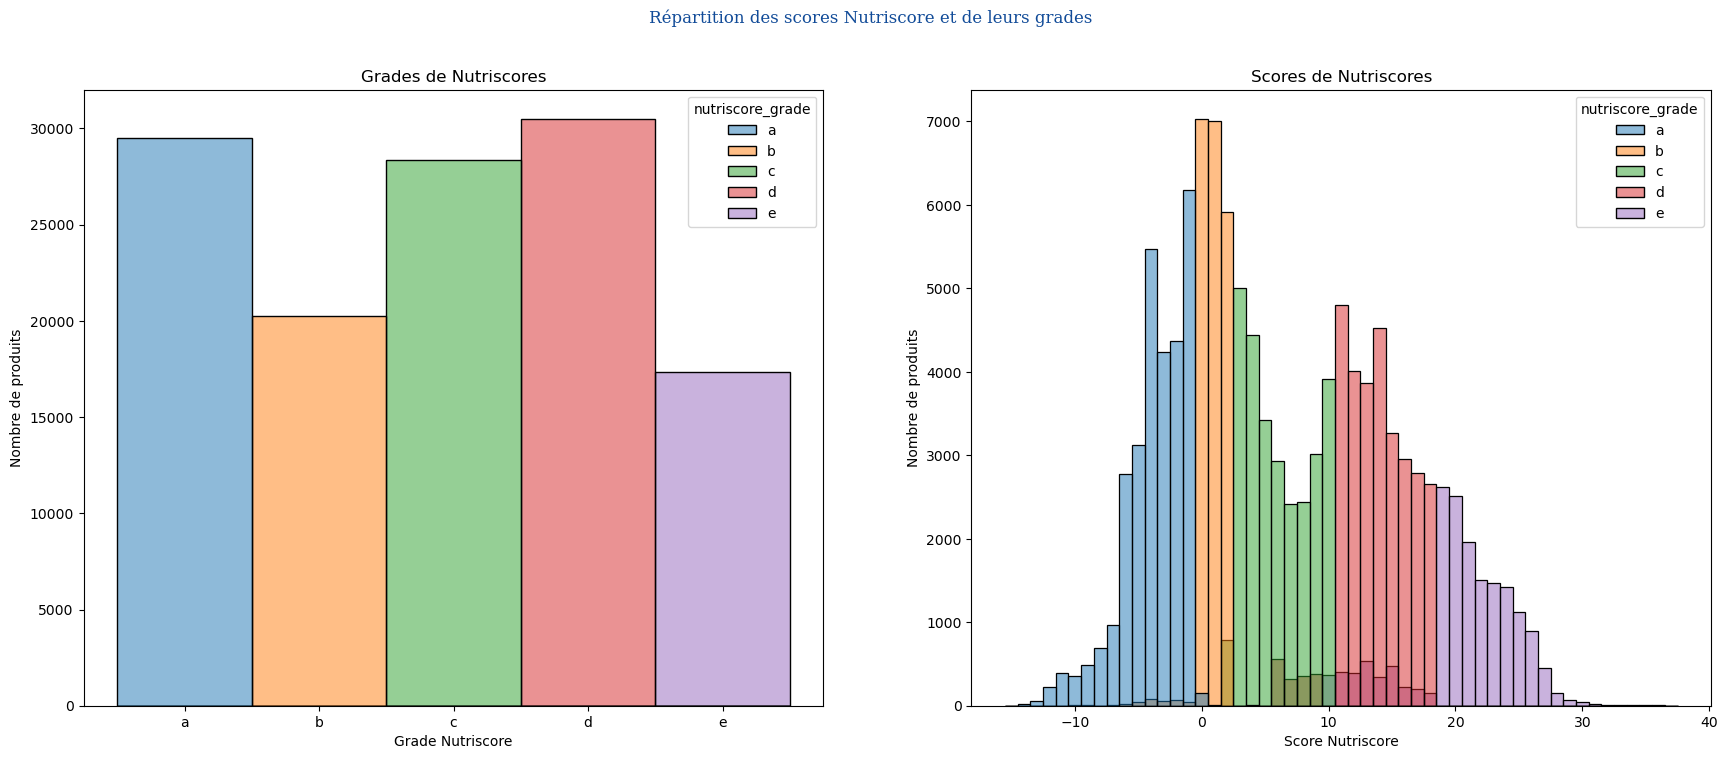

In [65]:
#On affiche la répartition du score brut du nutriscore, avant transformation en grade

# Filtrer les données pour exclure la catégorie 'Unknown' et 'non-applicable'
filtered_data = df_france[(df_france["nutriscore_grade"] != 'unknown') & (df_france["nutriscore_grade"] != 'not-applicable')]

    
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(21,8))
fig.suptitle("Répartition des scores Nutriscore et de leurs grades" "\n", fontdict=font_title)

sns.histplot(data=filtered_data.sort_values("nutriscore_grade"), x="nutriscore_grade", hue="nutriscore_grade", ax=axes[0])
axes[0].set_title('Grades de Nutriscores')
axes[0].set_xlabel("Grade Nutriscore")
axes[0].set_ylabel("Nombre de produits")


sns.histplot(data=filtered_data.sort_values("nutriscore_grade"), x="nutriscore_score", hue="nutriscore_grade", ax=axes[1])
axes[1].set_title('Scores de Nutriscores')
axes[1].set_xlabel("Score Nutriscore")
axes[1].set_ylabel("Nombre de produits")

plt.show()

On étudie la qualité de la nourriture sous 3 aspects : écologie, nutritionelles et transformations. 
On va utiliser une heatmap pour voir s'il n'existe pas déjà des corrélations entre les variables




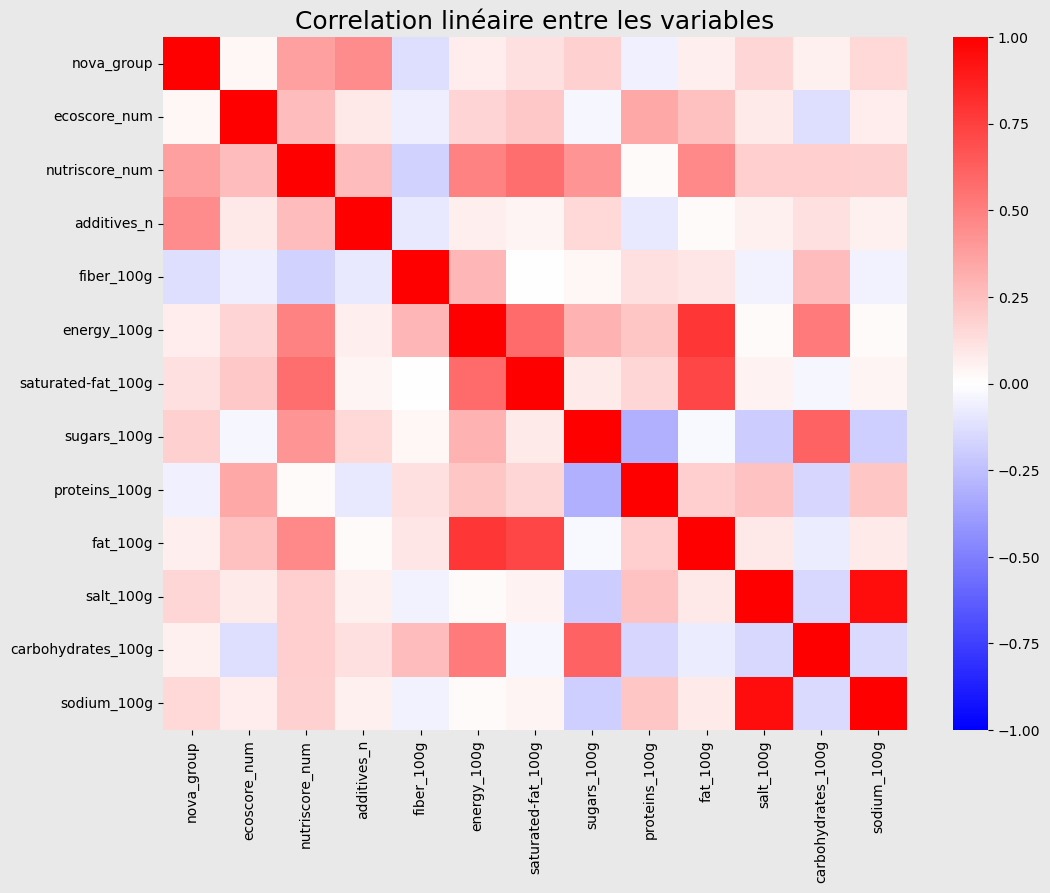

In [112]:
variable = ['additives_n','energy_100g', 'fat_100g'
        , 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'nutriscore_num', 'ecoscore_num', 'nova_group']

x=df_france.loc[:, variables]
x = x.dropna()
 
#calculate the correlation matrix
corr = x.corr()

lab=x.columns
#plot the heatmap
fig=plt.figure(figsize=[12,9])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)

plt.title("Correlation linéaire entre les variables",size=18)
ax=sns.heatmap(corr, vmin=-1, vmax=1,cmap="bwr",
        xticklabels=variables,
        yticklabels=variables)


In [ ]:
II. Partie analyse

A partir de cette liste, en modifiant à la main, on va garder uniquement les variables que je souhaite étudier pour la suite. 

On va désormais élargir notre analyse en prenant en compte de nouveaux critères qui sont importants lorsqu'on souhaite mieux s'alimenter: le degré de transformation, les additifs et la provenance des produits. On va essayer de créé des variables de scoring pour ces trois catégories avant de faire une comparaison avec le Nutri-Score étudié au dessus. 

1. Analyse du degré de transformation

Pour cette variable, le principal problème est la quantification de la transformation du produit alimentaire. Une approche simple serait de considérer que plus un produit alimentaire contient d'ingrédient, plus il est transformé. 


In [ ]:
# Afficher les valeurs uniques de la colonne 'main_category_fr'
valeurs_main_category_fr = df_france['food_groups_tags'].unique()

# Afficher les valeurs
print(valeurs_main_category_fr)


['en:fruits-and-vegetables,en:vegetables'
 'en:milk-and-dairy-products,en:dairy-desserts' nan
 'en:fats-and-sauces,en:dressings-and-sauces'
 'en:beverages,en:fruit-juices' 'en:sugary-snacks,en:sweets'
 'en:composite-foods,en:one-dish-meals'
 'en:composite-foods,en:pizza-pies-and-quiches'
 'en:fruits-and-vegetables,en:fruits'
 'en:fish-meat-eggs,en:meat,en:poultry'
 'en:beverages,en:sweetened-beverages'
 'en:milk-and-dairy-products,en:cheese' 'en:cereals-and-potatoes,en:bread'
 'en:fish-meat-eggs,en:fish-and-seafood,en:fatty-fish'
 'en:cereals-and-potatoes,en:legumes'
 'en:fish-meat-eggs,en:meat,en:meat-other-than-poultry'
 'en:sugary-snacks,en:biscuits-and-cakes'
 'en:salty-snacks,en:salty-and-fatty-products'
 'en:fruits-and-vegetables,en:dried-fruits' 'en:fats-and-sauces,en:fats'
 'en:cereals-and-potatoes' 'en:beverages,en:unsweetened-beverages'
 'en:cereals-and-potatoes,en:cereals' 'en:alcoholic-beverages'
 'en:salty-snacks,en:nuts' 'en:salty-snacks,en:appetizers'
 'en:sugary-snacks,